# Générer environnement




In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import Libraries

# Importations pour la construction du modèle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LeakyReLU
from sklearn.model_selection import train_test_split

# Importation pour la transformation sur les images
import tensorflow as tf
from tensorflow.keras.layers import Resizing
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import layers, models
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import RandomBrightness
from tensorflow.keras.layers import RandomContrast
from tensorflow.keras.layers import RandomTranslation

# Importation callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import Callback
from timeit import default_timer as timer


# Importation de l'utilitaire image_dataset_from_directory de Keras
from keras.utils import image_dataset_from_directory

# Importation pour les visualisations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline
import cv2
import os


from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# Initialisation des graines aléatoires pour la reproductibilité
import random
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
np.random.seed(24)
random.seed(24)
tf.random.set_seed(24)
tf.keras.utils.set_random_seed(24)
tf.config.experimental.enable_op_determinism()

# Preprocessing des images et des masques

## *Préparer les images et les séparer en échantillons*

Dans cette section nous utilisons une fonction spéciale consue pour:
- Remplir le tableau des métadonnées avec:
    - L'URL des images et masques
- Redimenssionner les masques 
    - Les sauver dans le dossier des données traitées
- Si l'argument 'mask_image' est vrai
    - Soustraire les masques redimenssionés aux images
    - Sauver les images masquées dans le dossier des données traitées
- Séparer les images (masquées ou pas) en échantillons d'entraînement, de test et de validation
    - Les sauvegarder dans des sous-dossiers distincts afin d'être récupérés

In [ ]:
from Libraries import Preprocesssing_images_masks
metadata=pd.read_csv('../data/processed/metadata.csv')

Preprocesssing_images_masks.preprocess_images(metadata,mask_images=True)

Ici nous donnons un exemple de contrôle visuel du redimenssionement des images

data\raw\COVID\masks\COVID-1.png


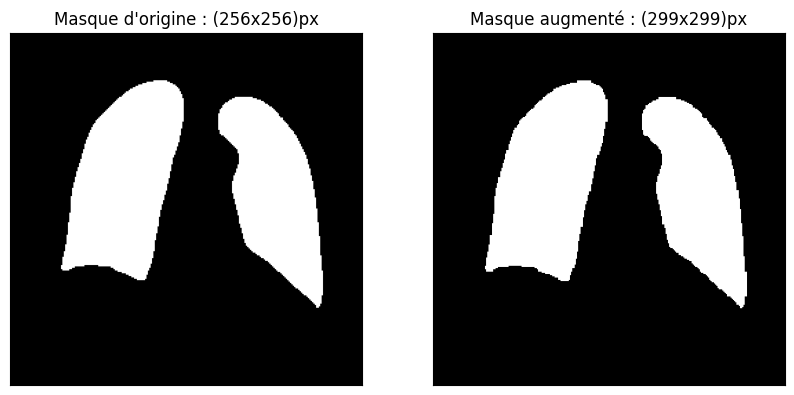

In [19]:
from Libraries import get_absolute_path

mask = cv2.imread(get_absolute_path.get_absolute_path(metadata.loc[0, "MASK_URL"]), cv2.IMREAD_GRAYSCALE)
print(metadata.loc[0, "MASK_URL"])
# Dans notre cas, la méthode d'interpolation la plus adaptée pour augmenter l'image semble être une interpolation nearest car elle ne va pas créer de
# valeur intermédiare entre 0 et 255, ce qui pourrait introduire des biais dans le modèle en fusionant avec les images d'origine
mask_resized = cv2.resize(mask, dsize=(299,299), interpolation=cv2.INTER_NEAREST)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(mask, cmap='gray')
plt.title(f"Masque d'origine : ({mask.shape[0]}x{mask.shape[1]})px")
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(mask_resized, cmap='gray')
plt.title(f"Masque augmenté : ({mask_resized.shape[0]}x{mask_resized.shape[1]})px")
plt.xticks([])
plt.yticks([])
plt.show()

# Chargement des images,Callbacks et Data Augmentation

## *Chargement des images*


Ici nous chargeons les images de nos échantillons, ces images seront:
- labellisées sous forme d'entiers
- chargées de manière aléatoire (Shuffle) par batch de:
    - 32 images pour l'entraînement
    - 64 images pour la validation
    - 64 images pour le test
- chargées en nuances de gris

Les images sont ensuite mises en cache afin d'optimiser l'utilisation de mémoire. Finalement nous créons ici le dictionnaire "class_weights" qui calcul le biais à donner à l'entraînement de notre modèle, compte-tenu du déséquilibre des classes dans notre jeu de données.

In [ ]:
train_folder='../data/processed/train_test_split/train'
validation_folder='../data/processed/train_test_split/validation'
test_folder='../data/processed/train_test_split/test'


train_ds=image_dataset_from_directory(train_folder,
                                    # Encodage des labels en entiers
                                    label_mode='int',
                                    # Chargement aléatoires des images dans les batchs
                                    shuffle=True,
                                    # Chargement en nuances de gris
                                    color_mode='grayscale',
                                    # Taille du batch
                                    batch_size=32,
                                    # Tailles des images
                                    image_size=(299,299),
                                      seed=42)

val_ds=image_dataset_from_directory(validation_folder,
                                     label_mode='int',
                                    shuffle=True,
                                    color_mode='grayscale',
                                    batch_size=64,
                                    image_size=(299,299),
                                    seed=42)

test_ds=image_dataset_from_directory(test_folder,
                                     label_mode='int',
                                     shuffle=True,
                                     color_mode='grayscale',
                                     batch_size=64,
                                     image_size=(299,299),
                                     seed=42)

# Nombre de lot dans l'ensemble d'entraînement
print("Nombre de batch dans train_ds:", train_ds.cardinality().numpy())

# Nombre de lot dans l'ensemble de test
print("Nombre de batch dans val_ds:", test_ds.cardinality().numpy())

# Nombre de lot dans l'ensemble de validation
print("Nombre de batch dans val_ds:", val_ds.cardinality().numpy())

import tensorflow as tf
# Optimisation du chargement
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

labels = np.concatenate([y for x, y in train_ds], axis=0)

# Calcul des poids des classes
class_labels = np.unique(labels)
class_weight = compute_class_weight(class_weight='balanced', classes=class_labels, y=labels)
class_weight_dict = dict(enumerate(class_weight))

print("Poids des classes :", class_weight_dict)

Found 16932 files belonging to 4 classes.
Found 2116 files belonging to 4 classes.
Found 2117 files belonging to 4 classes.


## *Callbacks et Data Augmentation*

In [ ]:

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)


# Early stopping, attente de 10 epochs ou la valeur de la fonction de perte pendant la validation ne descend pas de plus de 0.01
# On conserve les poids de la meilleure epoch
early_stopping = EarlyStopping(
                                patience=20,
                                min_delta=0.01,
                                verbose=1,
                                mode='min',
                                monitor='val_loss',
                                restore_best_weights= True)

# ReduceLR de facteur 2 si la valeur de la fonction de perte ne bouge pas de au moins 0.01, on attend 4 epochs
# avant de réitérer
reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3,
                                    min_delta=0.01,
                                    factor=0.5,
                                    cooldown=4,
                                    verbose=1)

# Ce Callback permet la sauvegarde du modèle en conservant les poids de l'epoch durant laquelle la valeur de la fonction de perte est la plus basse
model_path=r"../models/AC/model_DL_Convol.keras"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_path,
                                                      monitor='val_loss',
                                                      verbose=0,
                                                      save_best_only=True,
                                                      mode='min')

time_callback = TimingCallback()



# Data augmentation
data_augmentation = tf.keras.Sequential([
    # Faire pivoter aléatoirement l'image
    RandomFlip("horizontal"),
    # Appliquer une rotation aléatoire à l'image en remplissant les espaces laissés par des pixels noirs
    RandomRotation(0.1,fill_mode='constant', fill_value= 0),
    # Appliquer un zoom/dézoom aléatoire à l'image en remplissant les espaces laissés par des pixels noirs
    RandomZoom(0.2,fill_mode='constant',fill_value=0),
    # Modifier aléatoirement la luminosité des images
    RandomBrightness(0.2),
    # Translater les images dans toutes les directions en remplissant les espaces laissés par des pixels noirs
    RandomTranslation(0.2, 0.2, fill_mode='constant', fill_value=0),
])



Dans cette cellule, on affiche des images aléatoires ayant subi les augmentations détaillées dans la cellule précédentes.

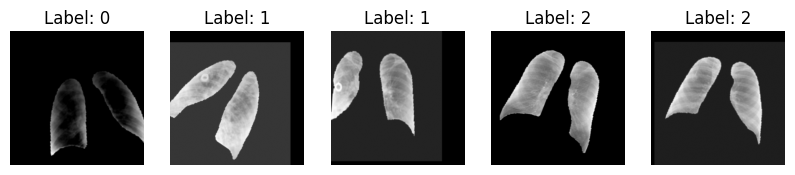

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Fonction pour afficher des images avec augmentation
def plot_random_augmentations(dataset, augmenter, num_images=5):
    plt.figure(figsize=(10, 10))

    for i, (image, label) in enumerate(dataset.take(num_images)):  # Prendre un échantillon aléatoire
        augmented_image = augmenter(image)  # Appliquer l'augmentation

        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(augmented_image[0].numpy().squeeze(), cmap='gray')
        plt.title(f"Label: {label.numpy()[0]}")
        plt.axis("off")
    plt.savefig('../data/processed/Figures/Data_Augmentation.png')
    plt.show()

# Afficher quelques exemples d'images augmentées
plot_random_augmentations(train_ds, data_augmentation)



# Deep Learning

## *Modèle convolutif 1*

Nous avons mis en place un premier modèle convolutif assez simple afin d'étudier les résultats sur notre jeu de données. Celui-ci se compose:
- 4 couches convolutives aux nombre de filtres décroissant (256 -> 32)
- Chaque couche de convolution est suvie d'une couche de pooling avec un kernel de (5,5) puis de (3,3).
- 2 couches de dropout afin de limiter les problèmes d'overfitting
- Une couche d'aplatissement pour passer aux couches denses
- 2 couches denses au nombre de neurones décroissant (32,4), la dernière couche donnant le nombre de classes en sortie du modèle.

Nous utilisons pour ce modèle un optimisateur Adam avec un taux d'apprentissage de départ de 0.001. Nous avons choisi de compiler le modèle avec une fonction de perte sparse_crossentropy idéale pour la classification multi-classes avec des labels de classe encodés en entiers. Finalement nous avons choisi la métrique 'accuracy' bien adaptée à l'éavaluation des performances d'une modèle de classification. 

In [ ]:


inputs = tf.keras.Input(shape=(299, 299, 1))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(256, (5,5), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(128, (5,5), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Dropout(0.4)(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])
model.summary()


Ici nous entraînons le modèle précédemment compilé sur nos données d'entraînement en gardant un échantillon de validation.
L'entraînement se fait sur 50 epochs avec tous les callbacks définis et une augmentation des données. Il est également efefctué avec le biais des poids relatifs des différentes classes.

In [ ]:

# Entrainement du modèle
model_history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=50,
      callbacks=[reduce_learning_rate, early_stopping, model_checkpoint],
      class_weight=class_weight_dict
  )


# Stocker les valeurs des fonctions de pertes et de l'accuracy durant chaque epoch de l'entraînement
train_loss = model_history.history["loss"]
val_loss = model_history.history["val_loss"]
# Stocker les résultats de la meilleure epoch conservée par notre callback
best_epoch_loss=(val_loss.index(min(val_loss)),min(val_loss))

train_accuracy = model_history.history["accuracy"]
val_accuracy = model_history.history["val_accuracy"]
best_epoch_acc=(val_accuracy.index(min(val_accuracy)),min(val_accuracy))



Dans cette cellule nous représentons graphiquement les performances du modèle durant son entraînement en spécifiant quelle epoch a été sélectionnée par notre callback

In [ ]:
plt.figure(figsize=(20, 8))

# Tracer la sparse cross-entropy
plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.scatter(best_epoch_loss[0],best_epoch_loss[1],s=10)
plt.title('Perte du modèle par époque (cross-entropy)')
plt.ylabel('Perte (sparse_crossentropy)')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation','Best epoch'], loc='best')

# Tracer l'accuracy
plt.subplot(122)
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.scatter(best_epoch_acc[0],best_epoch_acc[1],s=10)
plt.title('Accuracy par époque')
plt.ylabel('Accuracy')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation', 'Best epoch'], loc='best')

plt.savefig('../reports/figures/Loss_Accuracy_DL_Convol_1.png')
plt.show()


Dans cette cellule nous détaillons le rapport de classification de notre modèle entraîné sur l'échantillon de test et affichons la matrice du confusion de cette classification. Les deux éléments sont alors sauvegardés dans le dossier reports.

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

test_pred_model = model.predict(test_ds)
test_pred_class = test_pred_model.argmax(axis=1)
y_test_class = np.concatenate([y for x, y in test_ds], axis=0)
print(classification_report(y_test_class, test_pred_class))
dict_classif=classification_report(y_test_class, test_pred_class)
np.save('../reports/Classification_report_DL_Convol_1.txt', dict_classif)

data = confusion_matrix(y_test_class, test_pred_class)
df_cm = pd.DataFrame(data, columns=np.unique(y_test_class), index = np.unique(y_test_class))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 10},fmt='g')# font size
plt.savefig('../reports/Figures/Confusion_matrix__DL_Convol_1.png')

Dans cette cellule on plot des exemples de classification ratées et/ou réussies par notre modèles à l'aide d'une fonction custom.

In [ ]:
from Libraries import Plot_decisions_classif

Plot_decisions_classif.plot_classification_results(model,test_ds,plot_errors=True,num_samples=3)
plt.savefig('../reports/figures/False_predictions_CNN1.png')

Plot_decisions_classif.plot_classification_results(model,test_ds,plot_errors=False,num_samples=3)
plt.savefig('../reports/figures/True_predictions_CNN1.png')


## *Modèle convolutif 2*

Dans notre premier modèle nous avions 4 couches de convolutions aux filtres décroissants et 2 couches denses au nombre de neurones décroissants. Maintenant, nous allons essayer un nouveau modèle plus complexe

Mise en place du nouveau modèle, le nombre de filtres des couches convolutives augmente (32,64,128,256,512) et celui des couches denses diminue. On a ajouté une couche de convolution par rapport au modèle précédent. Nous avons également allégé le dropout afin de conserver le plus de données.

In [ ]:

inputs = tf.keras.Input(shape=(299, 299, 1))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(32, (5,5), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(64, (5,5), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(128, (5,5), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(512, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Dropout(0.3)(x)
x = layers.Flatten()(x)
# Pas besoin de 256 neurones, il faut descendre entre convol et dense
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])
model.summary()

Entraînement du modèle

In [ ]:
# Ce Callback permet la sauvegarde du modèle en conservant les poids de l'epoch durant laquelle la valeur de la fonction de perte est la plus basse
# Il est important de le redéfinir lorsque l'on change de modèle
model_path=r"../models/AC/model_DL_Convol2.keras"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_path,
                                                      monitor='val_loss',
                                                      verbose=0,
                                                      save_best_only=True,
                                                      mode='min')


model_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[reduce_learning_rate, early_stopping, model_checkpoint],
    class_weight=class_weight_dict
)


# Stocker les valeurs des fonctions de pertes et de l'accuracy durant chaque epoch de l'entraînement
train_loss = model_history.history["loss"]
val_loss = model_history.history["val_loss"]
# Stocker les résultats de la meilleure epoch conservée par notre callback
best_epoch_loss=(val_loss.index(min(val_loss)),min(val_loss))

train_accuracy = model_history.history["accuracy"]
val_accuracy = model_history.history["val_accuracy"]
best_epoch_acc=(val_accuracy.index(min(val_accuracy)),min(val_accuracy))


Plot de l'entraînement du modèle

In [ ]:
plt.figure(figsize=(20, 8))

# Tracer la sparse cross-entropy
plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.scatter(best_epoch_loss[0],best_epoch_loss[1],s=10)
plt.title('Perte du modèle par époque (cross-entropy)')
plt.ylabel('Perte (sparse_crossentropy)')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation','Best epoch'], loc='best')

# Tracer l'accuracy
plt.subplot(122)
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.scatter(best_epoch_acc[0],best_epoch_acc[1],s=10)
plt.title('Accuracy par époque')
plt.ylabel('Accuracy')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation', 'Best epoch'], loc='best')

plt.savefig('../reports/figures/Loss_Accuracy_DL_Convol_2.png')

plt.show()



Rapport de classification et matrice de confusion

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

test_pred_model = model.predict(test_ds)
test_pred_class = test_pred_model.argmax(axis=1)
y_test_class = np.concatenate([y for x, y in test_ds], axis=0)
print(classification_report(y_test_class, test_pred_class))
dict_classif=classification_report(y_test_class, test_pred_class)
np.save('../reports/Classification_report_DL_Convol_2', dict_classif)

data = confusion_matrix(y_test_class, test_pred_class)
df_cm = pd.DataFrame(data, columns=np.unique(y_test_class), index = np.unique(y_test_class))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 10},fmt='g')# font size
plt.savefig('../reports/figures/Confusion_matrix__DL_Convol_2.png')

Représentation d'exemples de classification par le modèle.

In [ ]:
from Libraries import Plot_decisions_classif

Plot_decisions_classif.plot_classification_results(model,test_ds,plot_errors=True,num_samples=3)
plt.savefig('../reports/figures/False_predictions_CNN2.png')

Plot_decisions_classif.plot_classification_results(model,test_ds,plot_errors=False,num_samples=3)
plt.savefig('../reports/figures/True_predictions_CNN2.png')

# Transfer Learning

## *Transfer learning avec InceptionV3 sans augmentation de données*

Nous avons décidé d'utiliser InceptionV3 dans cette aprtie car ce modèle convolutif entraîne sur ImageNet a fait ses preuves dans les tâches de classifications multi-classes. En particulier, il a été utilisé dans l'imagerie scientifique et médicale afin de classififier des images issues des IRMs ou des microscopes.

Le modèle InceptionV3 nécessite cependant un pré-traitement des images. Celles-ci doivent-être de 299 x 299 pixels, sous le format RGB et la valeur de leurs pixels doit être comprise entre -1 et 1. Nous passons donc dans la cellule suivante au pré-traitement de nos images.

In [ ]:
import numpy as np
from tensorflow.keras.applications.inception_v3 import preprocess_input
import tensorflow as tf

# Convertir 1 canal en 3 canaux
def convert_to_rgb(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label

train_ds = train_ds.map(convert_to_rgb)
val_ds = val_ds.map(convert_to_rgb)
test_ds = test_ds.map(convert_to_rgb)

# Normalisation des valeurs de pixel entre -1 et 1
def preprocess(image, label):
    image = preprocess_input(image)  # Normalisation [-1, 1]
    return image, label

train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

Dans cette cellule nous mettons en place la strcuture du modèle. Dans un premier temps, nous compilons le modèle sans couche de données augmentées et nous gardons le modèle InceptionV3 tel quel, c'est à dire entraîné sur ImageNet en gelant toutes ses couches.

Nous ajoutons simplement des couches denses au nombre de neurones décroissants (256,128,32,16,4) et des couches de dropout de plus en plus restrictives.

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten

num_classes=4
# Importation du modèle InceptionV3 pré-entraîné
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
# Gel de toutes ses couches
base_model.trainable = False

x= base_model.output
x= GlobalAveragePooling2D()(x)
x=Dense(256, activation='relu')(x)
x=Dropout(0.1)(x)
x=Dense(128, activation='relu')(x)
x=Dense(32, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(16, activation='relu')(x)
x=Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=outputs)






optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])

model.summary()

Dans cette cellule nous entraînons le modèle avec nos callbacks habituels, le biais de déséquilibre et le même nombre d'epochs.

In [ ]:
# Ce Callback permet la sauvegarde du modèle en conservant les poids de l'epoch durant laquelle la valeur de la fonction de perte est la plus basse
model_path=r"../models/AC/model_TL_InceptionV3_1.keras"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_path,
                                                      monitor='val_loss',
                                                      verbose=0,
                                                      save_best_only=True,
                                                      mode='min')


model_history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=50,
      callbacks=[reduce_learning_rate, early_stopping, model_checkpoint],
      class_weight=class_weight_dict
  )

Dans cette cellule nous affichons le rapport de classification ainsi que la matrice de confusion de notre modèle.

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

test_pred_model = model.predict(test_ds)
test_pred_class = test_pred_model.argmax(axis=1)
y_test_class = np.concatenate([y for x, y in test_ds], axis=0)
print(classification_report(y_test_class, test_pred_class))
dict_classif=classification_report(y_test_class, test_pred_class)
np.save('../reports/Classification_report_TL_InceptionV3_1', dict_classif)

data = confusion_matrix(y_test_class, test_pred_class)
df_cm = pd.DataFrame(data, columns=np.unique(y_test_class), index = np.unique(y_test_class))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 10},fmt='g')# font size
plt.savefig('../reports/figures/Confusion_matrix__TL_InceptionV3_1.png')

On voit ici que notre modèle de transfer learning InceptionV3  sans data augmentation nous donne des résultats moins bons que ceux obtenus avec un CNN classique.

## *InceptionV3 Avec Data Augmentation*

Ici on reprend le même modèle que précédemment, on y introduit cependant une couche de data augmentation en amont de InceptionV3.

In [ ]:

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten

num_classes=4
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False


x=base_model.input
x=data_augmentation(x)
x= base_model.output
x= GlobalAveragePooling2D()(x)
x=Dense(256, activation='relu')(x)
x=Dropout(0.1)(x)
x=Dense(128, activation='relu')(x)
x=Dense(32, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(16, activation='relu')(x)
x=Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])

model.summary()

Entraîner le modèle avec data augmentation

In [ ]:
model_path=r"../models/AC/model_TL_InceptionV3_AUGMENTED.keras"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_path,
                                                      monitor='val_loss',
                                                      verbose=0,
                                                      save_best_only=True,
                                                      mode='min')

model_history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=50,
      callbacks=[reduce_learning_rate, early_stopping, model_checkpoint],
      class_weight=class_weight_dict
  )

In [ ]:
plt.figure(figsize=(20, 8))

# Stocker les valeurs des fonctions de pertes et de l'accuracy durant chaque epoch de l'entraînement
train_loss = model_history.history["loss"]
val_loss = model_history.history["val_loss"]
# Stocker les résultats de la meilleure epoch conservée par notre callback
best_epoch_loss=(val_loss.index(min(val_loss)),min(val_loss))

train_accuracy = model_history.history["accuracy"]
val_accuracy = model_history.history["val_accuracy"]
best_epoch_acc=(val_accuracy.index(min(val_accuracy)),min(val_accuracy))

# Tracer la sparse cross-entropy
plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.scatter(best_epoch_loss[0],best_epoch_loss[1],s=10)
plt.title('Perte du modèle par époque (cross-entropy)')
plt.ylabel('Perte (sparse_crossentropy)')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation','Best epoch'], loc='best')

# Tracer l'accuracy
plt.subplot(122)
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.scatter(best_epoch_acc[0],best_epoch_acc[1],s=10)
plt.title('Accuracy par époque')
plt.ylabel('Accuracy')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation', 'Best epoch'], loc='best')

plt.show()

plt.savefig('../reports/figures/Loss_Accuracy_TL_InceptionV3_AUGMENTED.png')

Rapport de classification et Matrice de confusion

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

test_pred_model = model.predict(test_ds)
test_pred_class = test_pred_model.argmax(axis=1)
y_test_class = np.concatenate([y for x, y in test_ds], axis=0)
print(classification_report(y_test_class, test_pred_class))
dict_classif=classification_report(y_test_class, test_pred_class)
np.save('../reports/Classification_report_TL_InceptionV3_AUGMENTED', dict_classif)

data = confusion_matrix(y_test_class, test_pred_class)
df_cm = pd.DataFrame(data, columns=np.unique(y_test_class), index = np.unique(y_test_class))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 10},fmt='g')# font size
plt.savefig('../reports/figures/Confusion_matrix__TL_InceptionV3_AUGMENTED.png')

Les résultats obtenus par notre modèle sont les mêmes avec des images augmentées que sans augmentation. Peut-être le dégel de quelques couches de InceptionV3 pourront nous donner une classification plus performante.

## *Transfer Learning avec InceptionV3: Dégel du dernier block.*

Après avoir étudié les résultats de la classification faite par InceptionV3, il semblerait que nous sommes dans la bonne direction. Nous décidons alors de conserver l'augmentation des données réalisées précédemment et de ré-entraîner une partie du modèle InceptionV3.

Nous ajoutons donc un terme permettant le dégel des 87 dernières couches d'InceptionV3, correspondant au dernier block de convolution de celui-ci.

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten

num_classes=4

# Charger le modèle pré-entraîné sans la couche de classification finale
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in base_model.layers:
  layer.trainable = False
# Geler toutes les couches du modèle de base

# Dégel du dernier block du modèle (mixed10)
for layer in base_model.layers[-87:]:  # Approximativement le dernier block. 
  layer.trainable = True

# Ajouter des couches personnalisées pour la classification
x=base_model.input
x=data_augmentation(x)
x= base_model.output
x= GlobalAveragePooling2D()(x)
x=Dense(256, activation='relu')(x)
x=Dropout(0.1)(x)
x=Dense(128, activation='relu')(x)
x=Dense(32, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(16, activation='relu')(x)
x=Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])


# Résumé du modèle
model.summary()


Nous entraînons alors le modèle sur nos données

In [ ]:
model_path=r"../models/AC/model_TL_InceptionV3_RETRAINED.keras"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_path,
                                                      monitor='val_loss',
                                                      verbose=0,
                                                      save_best_only=True,
                                                      mode='min')

model_history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=100,
      callbacks=[reduce_learning_rate, early_stopping, model_checkpoint],
      class_weight=class_weight_dict
  )

Nous représentons graphiquement les performances de celui-ci durant son entraînement.

In [ ]:
plt.figure(figsize=(20, 8))

# Stocker les valeurs des fonctions de pertes et de l'accuracy durant chaque epoch de l'entraînement
train_loss = model_history.history["loss"]
val_loss = model_history.history["val_loss"]
# Stocker les résultats de la meilleure epoch conservée par notre callback
best_epoch_loss=(val_loss.index(min(val_loss)),min(val_loss))

train_accuracy = model_history.history["accuracy"]
val_accuracy = model_history.history["val_accuracy"]
best_epoch_acc=(val_accuracy.index(min(val_accuracy)),min(val_accuracy))

# Tracer la sparse cross-entropy
plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.scatter(best_epoch_loss[0],best_epoch_loss[1],s=10)
plt.title('Perte du modèle par époque (cross-entropy)')
plt.ylabel('Perte (sparse_crossentropy)')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation','Best epoch'], loc='best')

# Tracer l'accuracy
plt.subplot(122)
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.scatter(best_epoch_acc[0],best_epoch_acc[1],s=10)
plt.title('Accuracy par époque')
plt.ylabel('Accuracy')
plt.xlabel('Époque')
plt.legend(['Entraînement', 'Validation', 'Best epoch'], loc='best')

plt.savefig('../reports/figures/Loss_Accuracy_TL_InceptionV3_RETRAINED.png')
plt.show()




Nous affichons finalement son rapport de classification et sa matrice de confusion

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

test_pred_model = model.predict(test_ds)
test_pred_class = test_pred_model.argmax(axis=1)
y_test_class = np.concatenate([y for x, y in test_ds], axis=0)
print(classification_report(y_test_class, test_pred_class))
dict_classif=classification_report(y_test_class, test_pred_class)
np.save('../reports/Classification_report_TL_InceptionV3_RETRAINED', dict_classif)

data = confusion_matrix(y_test_class, test_pred_class)
df_cm = pd.DataFrame(data, columns=np.unique(y_test_class), index = np.unique(y_test_class))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 10},fmt='g')# font size
plt.savefig('../reports/figures/Confusion_matrix__TL_InceptionV3_RETRAINED.png')

Finalement, Nous affichons des exemples d'erreurs et de réussite de classification du modèle InceptionV3 modifié.

In [ ]:
from Libraries import Plot_decisions_classif

Plot_decisions_classif.plot_classification_results(model,test_ds,plot_errors=True,num_samples=3)
plt.savefig('../reports/figures/False_predictions_TL_InceptionV3_RETRAINED.png')

Plot_decisions_classif.plot_classification_results(model,test_ds,plot_errors=False,num_samples=3)
plt.savefig('../reports/figures/True_predictions_TL_InceptionV3_RETRAINED.png')